# Study of the effect of the environment in the multipoles of Pentacene
We would like to study here the effects of the environment in the value of the elecrostatic dipole developed by a Pentacene molecule in cluster of various sizes.

In [1]:
from BigDFT import Logfiles as L, Fragments as F
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Let us first define the function that decompose the system into the fragment's quantities, and apply this function into the FullQM cluster:

In [2]:
def get_pentacenes(filename):
    "Decompose the given system in pentacenes"
    RunLog=L.Logfile(filename)
    system=F.System(RunLog.electrostatic_multipoles,nat_reference=36,
                units=RunLog.log['Multipole coefficients']['units'])
    print 'The system given by file "'\
        +filename+'" has ',len(system.fragments),' fragments'
    return system

FullQM=get_pentacenes('log-FullQM.yaml')

The system given by file "log-FullQM.yaml" has  191  fragments


Extract the list of nearest neighbors for the different fragments in the system

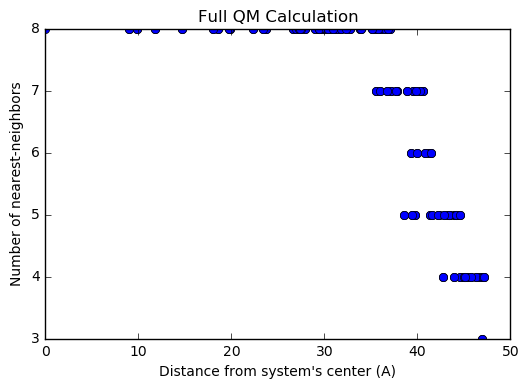

In [3]:
#distance from system's centroid of all the fragments
def distance_list(system):
    center=system.centroid()
    return [np.linalg.norm(r-center) for r in system.CMs]

dist=distance_list(FullQM)
#use a naive quadratic scheme
DistancesPP=[np.array([F.distance(f,g) for g in FullQM.fragments]) 
             for f in FullQM.fragments]
#then calculate nbumber nearest-neighbors below a threshold
NNthr=15.0
NN=[]
for i,f in enumerate(FullQM.fragments):
    inn=0
    for g in DistancesPP[i]:
        if g< NNthr and g !=0.0: inn+=1
    NN.append(inn)
plt.plot(dist,NN,'o')
plt.xlabel("Distance from system's center (A)")
plt.ylabel("Number of nearest-neighbors")
plt.title('Full QM Calculation')
plt.show()

From the above plot we see that the there are surface Pentacenes that lie starting from 
about 30 A from the central fragment.
Let us now correlate the surface effects with the norm of the dipole vector of the pentacene.
In order to do that we compare the induced dipole of each of the system's fragments.

The system given by file "gasphase/log-1.yaml" has  1  fragments
Norm of the induced dipole on the central pentacene (D): 0.0851493552668


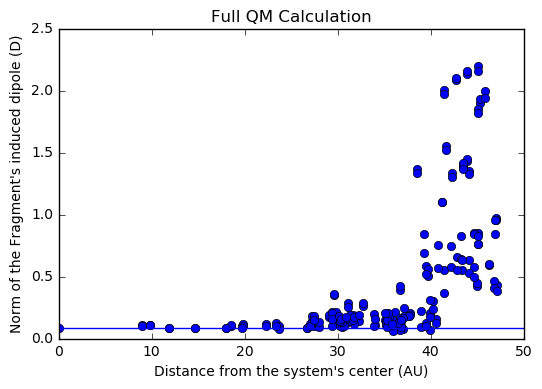

In [4]:
d0=get_pentacenes('gasphase/log-1.yaml').fragments[0].d1()
def dipole_list(system):
    return [np.linalg.norm(f.d1()-d0)/F.Debye_to_AU 
            for f in system.fragments]
dc=dipole_list(FullQM)[FullQM.central_fragment()]
print 'Norm of the induced dipole on the central pentacene (D):',dc
def analyse_system(system,label):
    plt.plot(distance_list(system),dipole_list(system),'o',label=label)
    plt.ylabel("Norm of the Fragment's induced dipole (D)")
    plt.xlabel("Distance from the system's center (AU)")
    plt.title('Full QM Calculation')
analyse_system(FullQM,'FullQM')
plt.axhline(dc,label='reference')
plt.show()

It is clear from this figure that the "external" fragments, which are "close enough" to the surface of the cluster are strongly polarized by the environmental effects. 

The internal fragments are weakly polarized. 
The induced dipole (ID) of the central Pentacene is only $8 \cdot 10^{-2}$ D.
Still, such value can be found to all the internal fragments and it is therefore measurable.
The average value of the measure can be found to be $(9.6\pm1.1) \cdot 10^{-2}$ D, see below.
Let us now try to reproduce the same value of the induced dipole on the central pentacene with different embedding techniques.

In [5]:
internal=20.0 # in AU (bohr)
closest_PENs=np.where(np.array(distance_list(FullQM)) < internal)[0]
closest_d1=np.array(dipole_list(FullQM))[closest_PENs]                      
print 'Average ID for fragments closest than ',\
    internal,' bohr: \n',\
    np.mean(closest_d1),' +- ',np.std(closest_d1),' D'

Average ID for fragments closest than  20.0  bohr: 
0.0962056942643  +-  0.0110042711852  D


In [6]:
def fragment_dipoles(files,purgebeta=False):
    for f in files:
        print f
        #custom treatment for eliminate old non-yaml compliant line
        fl=f
        if purgebeta:
            !cat $f | grep -v 'beta for' > tmp.yaml
            fl='tmp.yaml'
        Cluster=get_pentacenes(fl)
        #print dipole_list(Cluster)
        d1=Cluster.fragments[Cluster.central_fragment()].d1()
        print 'Norm of induced dipole on central pentacene: ',\
            np.linalg.norm(d1-d0)/F.Debye_to_AU
        analyse_system(Cluster,f)

## Gas phase fragments
We here analyse the dipoles of clusters of different sizes in the gas phase. We see that the central fragment develops a non-negligible dipole starting from a cluster of 9 molecules.

gasphase/log-1.yaml
The system given by file "gasphase/log-1.yaml" has  1  fragments
Norm of induced dipole on central pentacene:  0.0
gasphase/log-3.yaml
The system given by file "gasphase/log-3.yaml" has  3  fragments
Norm of induced dipole on central pentacene:  0.0580042984938
gasphase/log-5.yaml
The system given by file "gasphase/log-5.yaml" has  5  fragments
Norm of induced dipole on central pentacene:  0.0730661545495
gasphase/log-7.yaml
The system given by file "gasphase/log-7.yaml" has  7  fragments
Norm of induced dipole on central pentacene:  0.0921469071031
gasphase/log-9.yaml
The system given by file "gasphase/log-9.yaml" has  9  fragments
Norm of induced dipole on central pentacene:  0.101652965393


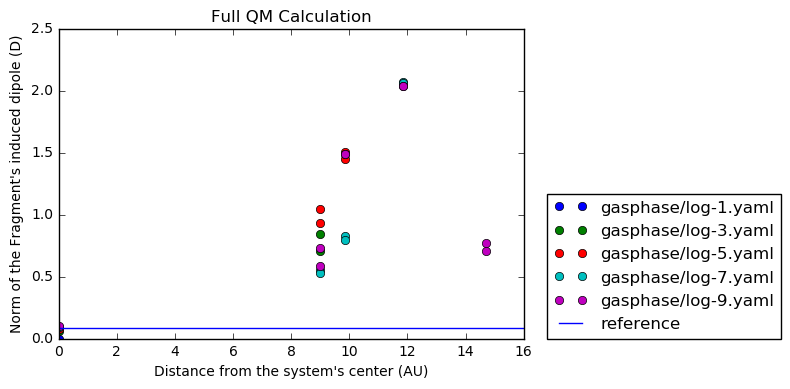

In [7]:
files=!ls gasphase/log*.yaml
fragment_dipoles(files)
plt.axhline(dc,label='reference')
plt.legend(loc=(1.05,0))
plt.show()

## Averaged-environment fragments
We then performed a calculation where a QM region of $n$ fragments is embedded into an environment of $191-n$ molecules. We assign to each of the  environmental fragment the average values of he multipoles obtained from the molecules that are closer than 20 AU from the center, such as to avoid surface effects. Such treatment is detailed in the script <tt>QMMMBuild.py</tt>.

In this case, we see that the induced dipole is *too strong*: the _averaged_ environment, even if taken from the
very fragments belonging to the internal region, is *overpolarizing* the fragments.
This phenomenon does not disappear, even for large clusters:

averaged/log-1.yaml
The system given by file "tmp.yaml" has  1  fragments
Norm of induced dipole on central pentacene:  1.41533127109
averaged/log-3.yaml
The system given by file "tmp.yaml" has  3  fragments
Norm of induced dipole on central pentacene:  1.37933955236
averaged/log-5.yaml
The system given by file "tmp.yaml" has  7  fragments
Norm of induced dipole on central pentacene:  1.31632529451
averaged/log-7.yaml
The system given by file "tmp.yaml" has  9  fragments
Norm of induced dipole on central pentacene:  1.31007487944
averaged/log-9.yaml
The system given by file "tmp.yaml" has  17  fragments
Norm of induced dipole on central pentacene:  1.31203695742


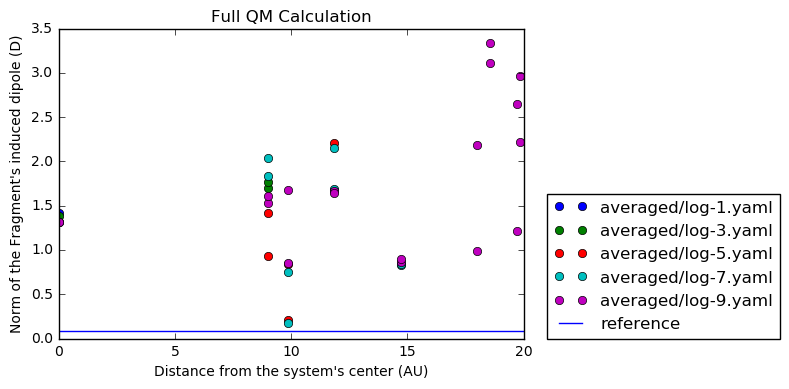

In [8]:
#the list of the files is there
files=!ls averaged/log-*
fragment_dipoles(files,purgebeta=True)
plt.axhline(dc,label='reference')
plt.legend(loc=(1.05,0))
plt.show()

## Fragment embedded in the actual QM/QMe environment
We have therefore considered the environment as the actual charges that each fragment  generate on the QM region.
In this case, things go at expected but *only* if we consider as QM region _at least_  three pentacenes.
Otherwise, for a single PEN the overpolarization phenomenon is still visible.

actual/log-1.yaml
The system given by file "actual/log-1.yaml" has  1  fragments
Norm of induced dipole on central pentacene:  0.843398355979
actual/log-3.yaml
The system given by file "actual/log-3.yaml" has  3  fragments
Norm of induced dipole on central pentacene:  0.115931108351
actual/log-5.yaml
The system given by file "actual/log-5.yaml" has  5  fragments
Norm of induced dipole on central pentacene:  0.122078056899
actual/log-7.yaml
The system given by file "actual/log-7.yaml" has  7  fragments
Norm of induced dipole on central pentacene:  0.078626563389
actual/log-9.yaml
The system given by file "actual/log-9.yaml" has  9  fragments
Norm of induced dipole on central pentacene:  0.0791819067078


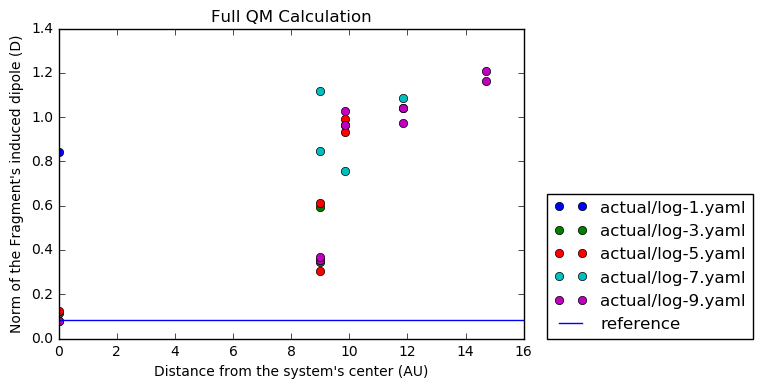

In [9]:
files=!ls actual/log*.yaml
fragment_dipoles(files)
plt.axhline(dc,label='reference')
plt.legend(loc=(1.05,0))#loc='upper left')
plt.show()

Here we can immediately see that the actual environment is the one that is able to match the fullQM dipoles *but only when* at least 3 fragments are considered.